In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PARQUET_ROOT = Path("../data/equity_data")
UNIVERSE_CSV = Path("../config/universes/2025-09_default_universe.csv")

sns.set_theme(style="whitegrid", context="talk")


In [4]:
uni = pd.read_csv(UNIVERSE_CSV)

if "symbol" in uni.columns:
    uni["symbol"] = uni["symbol"].astype(str).str.strip()
else:
    uni = uni.rename(columns={uni.columns[0]: "symbol"})
    uni["symbol"] = uni["symbol"].astype(str).str.strip()

if "bucket" not in uni.columns:
    uni["bucket"] = "stock"

bucket_map = dict(zip(uni["symbol"], uni["bucket"]))


In [8]:
df = pd.read_parquet(PARQUET_ROOT, engine="pyarrow", columns=["date", "ticker", "close"])
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").sort_index()

px = df.pivot_table(index=df.index, columns="ticker", values="close", observed=False).sort_index()

px = px.ffill().dropna(how="all")
px.head()


ticker,ADBE,ADYEN.AS,AMD,AMZN,BILI,CPNG,CRWD,CSPX.L,DDOG,DHER.DE,...,MELI,NFLX,NOW,NU,PDD,SE,SHOP,SNOW,SPOT,ZAL.DE
date,,,,,,,,,,,,,,,,,,,,,
1999-11-01,68.56,NaN,20.31,69.13,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-02,68.06,NaN,20.56,66.44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-03,68.81,NaN,21.31,65.81,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-04,68.88,NaN,20.63,63.06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-05,70.69,NaN,21.25,64.94,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:

first_valid = px.apply(lambda s: s.first_valid_index())
last_valid  = px.apply(lambda s: s.last_valid_index())
start = first_valid.max()
end   = last_valid.min()

px_common = px.loc[start:end].dropna(axis=1, how="any")
print(f"Common window: {start.date()} → {end.date()}  |  tickers kept: {len(px_common.columns)}")


Common window: 2021-12-09 → 2025-09-19  |  tickers kept: 22


In [20]:
# because of stocksplits in amazon and shopify during our common window, we have to further restrict data to dates after July 1st 2022
px_common = px_common.loc["2022-07-01":].dropna(axis=1, how="any")

In [21]:
norm = px_common / px_common.iloc[0]
long = norm.reset_index().melt(id_vars="date", var_name="ticker", value_name="equity")

long["bucket"] = long["ticker"].map(bucket_map).fillna("stock")
long.head()


,date,ticker,equity,bucket
0,2022-07-01,ADBE,1.000000,stock
1,2022-07-04,ADBE,1.000000,stock
2,2022-07-05,ADBE,1.021738,stock
3,2022-07-06,ADBE,1.038944,stock
4,2022-07-07,ADBE,1.060817,stock


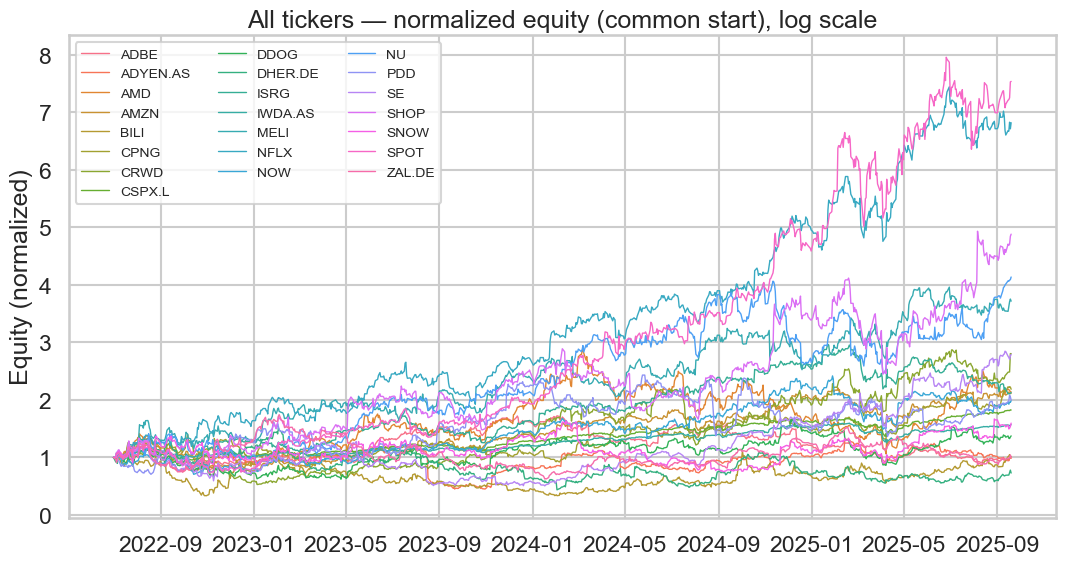

In [22]:
plt.figure(figsize=(11, 6))
ax = sns.lineplot(data=long, x="date", y="equity", hue="ticker", linewidth=1)
# ax.set_yscale("log")
ax.set_title("All tickers — normalized equity (common start), log scale")
ax.set_xlabel("")
ax.set_ylabel("Equity (normalized)")
ax.legend(title="", ncol=3, fontsize=10)
plt.tight_layout()
plt.show()


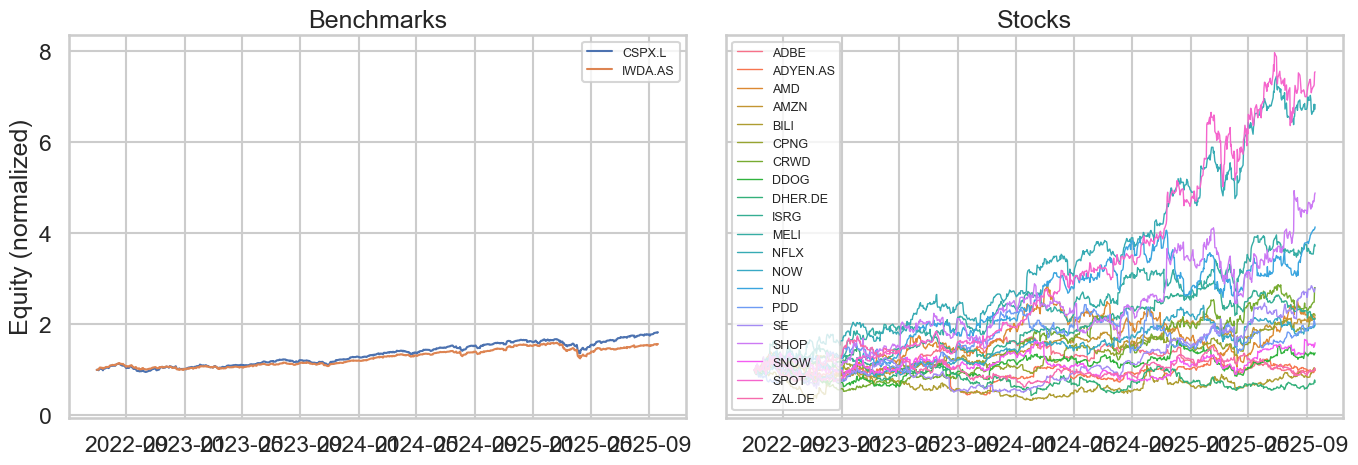

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# benchmarks
bench = long[long["bucket"].str.lower() == "benchmark"]
sns.lineplot(data=bench, x="date", y="equity", hue="ticker", ax=axes[0], linewidth=1.5)
axes[0].set_title("Benchmarks")
axes[0].set_xlabel("")
axes[0].set_ylabel("Equity (normalized)")
# axes[0].set_yscale("log")

# stocks
stocks = long[long["bucket"].str.lower() == "stock"]
sns.lineplot(data=stocks, x="date", y="equity", hue="ticker", ax=axes[1], linewidth=1)
axes[1].set_title("Stocks")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
# axes[1].set_yscale("log")

for ax in axes:
    ax.legend(title="", fontsize=9)
plt.tight_layout()
plt.show()
